# Imports

In [7]:
from ocr import OCRProcessor
from PIL import Image
from pathlib import Path
from ocr_enum import OCREngine
from image_diff import image_crop_dialogue_box
import matplotlib.pyplot as plt
import json

# Post Processing

In [29]:
def extract_string_between(text, start, end):
    try:
        start_index = text.index(start) + len(start)
        end_index = text.index(end, start_index)
        return text[start_index:end_index]
    except ValueError:
        return None

def clean_vision_model_output(response):
    if type(response) is str:
        text = response
    else:
        text = response['choices'][0]['message']['content']
    if '```' not in text:
        ocr_text = ""
    else:
        ocr_text = extract_string_between(text, "```", "```")
    if ocr_text is None:
        return ""
    cleaned_ocr_text = ocr_text.replace('\n', ' ')
    return cleaned_ocr_text

# Run OpenAI Translation

In [15]:
from dotenv import load_dotenv

import os
import base64
import requests

load_dotenv()
OpenAI_API_KEY = os.environ.get("OPENAI_ACCESS_TOKEN")

class OpenAI_API:
    
    def __init__(self, translation_model="gpt-3.5-turbo", 
                       vision_model="gpt-4o"):
        self.translation_model = translation_model
        self.vision_model = vision_model
        self.openai_url = "https://api.openai.com/v1/chat/completions"
        self.lang_list = {'en' : 'English', 'jp' : 'Japanese'}

    def call_api(self, payload):
        headers = {
            "Content-Type": "application/json",
            "Authorization": f"Bearer {OpenAI_API_KEY}"
        }

        response = requests.post(self.openai_url, headers=headers, json=payload)
        print(response.json())
        return response.json()

    def call_translation_api(self, content, target_lang):

        content = content if type(content) is str else f"{content.get('name', '')} : {content.get('dialogue', '')}"
        target_lang = self.lang_list.get(target_lang, target_lang)
        self.set_translation_payload(content, target_lang)

        payload = {
            "model": self.translation_model,
            "messages": self.translation_message,
            "max_tokens": 300
            }
        
        response_json = self.call_api(payload)
        
        return response_json
    
    def call_vision_api(self, image_bytes):
        # Getting the base64 string
        base64_image = base64.b64encode(image_bytes).decode('utf-8')

        self.set_vision_payload(base64_image)

        payload = {
        "model": self.vision_model,
        "messages": self.vision_message,
        "max_tokens": 300
        }

        response_json = self.call_api(payload)
        return response_json
    
    def set_translation_payload(self, content, target_lang):
        self.translation_message = [
                
                {
                                "role": "system",
                                "content": "You are trained to translate or make assumption about text.Correct typos in the text. You are a helpful and great assistant designed to output text in this format. ``` ```. You are NOT to output any other unnecessary texts. ONLY ``` ```.If there is no translation, you MUST ONLY OUTPUT ``` ```"
                },
                {
                    "role": "user",
                    "content": [
                        {
                        "type": "text",
                        "text": f"Translate this sentence into {target_lang}.\n{content}"
                        },
                ]
                }
            ]
    
    def set_vision_payload(self, base64_image):
        # self.vision_message = [
        #     {
        #     "role": "user",
        #     "content": [
        #         {
        #         "type": "text",
        #         "text": "What is the text in the photo?"
        #         },
        #         {
        #         "type": "image_url",
        #         "image_url": {
        #             "url": f"data:image/jpeg;base64,{base64_image}"
        #         }
        #         }
        #     ]
        #     }
        # ]
        self.vision_message = [
                                {
                                "role": "system",
                                "content": "You are trained to identify or make assumption about multilinugal text within images. You are a helpful and great assistant designed to output text in this format. ``` ```. You are NOT to output any other unnecessary texts. ONLY ``` ```.If there is not text in the photo, you MUST ONLY OUTPUT ``` ```"
                                },
                                {
                                "role": "user",
                                "content": [
                                                {
                                                "type": "text",
                                                "text": "What is the text in the photo? The text are "
                                                },
                                                {
                                                "type": "image_url",
                                                "image_url": {
                                                    "url": f"data:image/jpeg;base64,{base64_image}"
                                                }
                                                }
                                            ]
                                }
                            ]

In [16]:

from datetime import datetime
import io
import os
import requests
from cloudvision import detect_text_google_pil, detect_text_google, detect_text_and_draw_boxes
from thefuzz import fuzz
import pytesseract
import base64
import json
from PIL import Image
from image_diff import calculate_image_difference, calculate_image_hash_different, image_crop_in_top_half
import time
from thread_safe import shared_data_put_data, shared_data_put_line, ThreadSafeData
from PIL import Image, ImageDraw, ImageFont
from pathlib import Path
import pickle
import imagehash
from ocr import OCRProcessor
from ocr_enum import OCREngine

lang_dict = {'en' : 'english', 'jp' : 'japanese'}
class FrameProcessor:
    def __init__(self, language='en', disable_dialog=False, save_outputs=False, method=OCREngine.EASYOCR):
        self.counter = 0  # Convert the global variable to an instance attribute
        self.disable_dialog = disable_dialog
        self.method = method
        self.save_outputs = save_outputs
        if self.save_outputs:
            # Create output directories if they do not exist
            self.input_image_folder = Path("outputs/input_images")
            self.annotated_image_folder = Path("outputs/annotated_images")
            self.ocr_annotations_folder = Path("outputs/ocr_annotations")
            self.translation_folder = Path("outputs/translations")
            self.vision_model_output_folder = Path("outputs/ocr_openai_responses")

            self.create_output_dirs()

        self.lang = language
        if language == 'en':
            self.dialog_file_path = "dialogues_en_v2.json"
        elif language == 'jp':
            self.dialog_file_path = "dialogues_jp_v2.json"
        else:   
            raise("Invalid language")   
        self.ocr_processor =  OCRProcessor(self.lang, self.method) # comment this if you aren't using easy ocr

        if disable_dialog:
            self.dialogues = None
        else:
            self.dialogues = self.load_dialogues()
        #print(self.dialogues)
        #TODO remove this from this class and store this somewhere else, so its multi user
        self.previous_image = Image.new('RGB', (100, 100), (255, 255, 255))
        self.last_played = -1 #TODO this should be per user

        
        self.last_annotations = None

        self.openai_api = OpenAI_API(translation_model='gpt-4o')

        self.ocr_cache_pkl_path = Path('ocr_cache.pkl')
        self.translation_cache_pkl_path = Path('translation_cache.pkl')
        self.ocr_cache = self.load_cache('ocr')
        self.translation_cache = self.load_cache('translation')
    
    def load_cache(self, cache_type):
        if cache_type == "ocr":
            file = self.ocr_cache_pkl_path
        if cache_type == "translation":
            file = self.translation_cache_pkl_path
        if file.exists():
            with open(file, 'rb') as f:
                cache = pickle.load(f)
        else:
            cache = []
        return cache
    
    def update_cache(self, cache_type):
        if cache_type == "ocr":
            file = self.ocr_cache_pkl_path
            cache = self.ocr_cache
        if cache_type == "translation":
            file = self.translation_cache_pkl_path
            cache = self.translation_cache

        with open(file, 'wb') as f:
            pickle.dump(cache, f)
    
    def run_cache(self, img, cache_type):

        if cache_type == "ocr":
            cache = self.ocr_cache
        if cache_type == "translation":
            cache = self.translation_cache

        min_diff = 10000
        closest_entry = None
        current = imagehash.average_hash(img, 16)
        for index, value in enumerate(cache):
            diff = current - value['hash']
            if diff <= min_diff:
                min_diff = diff
                closest_entry = index
        if min_diff < 7:
            return closest_entry
        else:
            return None



    def load_dialogues(self):
        print("load_dialogues-")
        # File path to your JSON data
        file_path = self.dialog_file_path

        # Read JSON data from the file
        with open(file_path, 'r', encoding='utf8') as file:
            data = json.load(file)

        # Convert list to a numbered dictionary
        dialogues = {index: item for index, item in enumerate(data)}

        # Print the numbered dictionary
        for number, entry in dialogues.items():
            print(f"{number}: Name: {entry['name']}, Dialogue: {entry['dialogue']}")
        #    print(format_filename(number))
        
        return dialogues
    
    def split_current_text(self, current_text):
        """
        split current text into different speakers and dialogues
        """
        texts = []
        text = []

        for word in current_text.split()[1:]:
            if ":" in word:
                texts.append(' '.join(text))
                text = []
            else:
                text.append(word)
        if text:
            texts.append(' '.join(text))
        return texts



    def find_closest_entry(self, current_text):
        print(f"find_closest_entry- current_text: {current_text}")
        if "Contentless Cores Explore"   in current_text:
            print(f"skipping menu")
            return None
        
        if self.lang == 'jp':
            texts = [current_text]
        else:
            texts = self.split_current_text(current_text)
        
        closest_entry_numbers = []
        for text in texts:
            # Initialize variables to track the highest similarity and corresponding entry number
            if self.lang == 'jp':
                max_similarity_ratio = 0.1
            else:
                max_similarity_ratio = 0.33  # Start with your threshold
            closest_entry_number = None
            
            for number, entry in self.dialogues.items():
                dialogue = entry['dialogue']
                similarity_ratio = fuzz.ratio(text, dialogue) / 100.0  # Convert to a scale of 0 to 1
                #print(f"dialogue: {dialogue} -- similarity_ratio: {similarity_ratio} -- number {number}")
                
                # Update if this entry has a higher similarity ratio than current max and is above threshold
                if similarity_ratio > max_similarity_ratio:
                    max_similarity_ratio = similarity_ratio
                    closest_entry_number = number
            if closest_entry_number is not None:
                closest_entry_numbers.append(closest_entry_number)

        return closest_entry_numbers  # Return the entry number with the highest similarity ratio over 0.33

    def encode_image(self, image_path):
        with open(image_path, "rb") as image_file:
            return base64.b64encode(image_file.read()).decode('utf-8')

    @staticmethod
    def thefuzz_test(ocr_text):
        # Known script text
        known_text = "some known text here"

        # Calculate similarity score
        score = fuzz.ratio(ocr_text, known_text)

        print(score)  # This will print the similarity score as a percentage
    
    def run_ocr(self, image):
        start_time = time.time() # Record the start time

        output_text, highlighted_image, annotations, reg_result = self.ocr_processor.run_ocr(image)
        
        print("found text ocr----")
        print(output_text)
        print("----")
    
    
        end_time = time.time()
        print(f"Time taken: {end_time - start_time} seconds")
        if self.disable_dialog:
            return output_text, highlighted_image, annotations, reg_result
        
        #thefuzz_test(text)
        res = self.find_closest_entry(output_text)
        if  res != [] and res[0] != None:
            print("found entry ")
            print(res)
            if res == self.last_played:
                print("Already played this entry")
            else:
                print(f"shared_data_put_line---{res}")
                shared_data_put_line(res[0]+1)
                self.last_played = res[0]
        else:
            print("No entry found")        
        return res, highlighted_image, annotations, reg_result

    def translate_openai(self, content, target_lang):
        timestamp = datetime.now().strftime('%Y%m%d%H%M%S')
        
        result = self.openai_api.call_translation_api(content, target_lang)

        content =  result['choices'][0]['message']['content'] 
        
        cleaned_string = str(content)
        print(f"{cleaned_string=}")
        return cleaned_string, result
    
    def run_translation(self, content, translate):
        start_time = time.time() # Record the start time

        target_lang = translate.split(',')[1]
        str, result = self.translate_openai(content, target_lang)
        
        print("---- Translated Text ----")
        print(str)
        print("-----------------------")

        end_time = time.time()
        print(f"Time taken: {end_time - start_time} seconds")
                  
        return str, result

    def process_frame(self, frame_pil, frame_count, fps):
        """
        Process the frame: Save it to disk and possibly do more processing.
        """
        # Assume run_image is a function you want to run on the frame
        x, y = self.run_image(frame_pil)
        
        print(f"Frame at {frame_count//fps} seconds")
        return x,y

    def run_image(self, img, translate=None, enable_cache=False):
        print(self.previous_image)
        # percent_diff = calculate_image_difference(img, self.previous_image)
        hash_diff = calculate_image_hash_different(img, self.previous_image)
        # print(f'Images differ by {percent_diff:.2f}%')
        print(f"Images differ by {hash_diff}")

        # Decide whether to call OCR based on the difference
        # if percent_diff > 10:
        if hash_diff >= 7:
            # print("Images are more than 10% different. Proceed with OCR.")
            print("Images are more than 7 hamming distance. Proceed with OCR")

            # crop the image to top half
            img_crop = image_crop_in_top_half(img)

            # cache
            then = time.time()
            
            if enable_cache:
                closest_entry = self.run_cache(img_crop, 'ocr')
            else:
                closest_entry = None
            if closest_entry:
                print('---run_cache_ocr---')
                data = self.ocr_cache[closest_entry]
                last_played = data['string']
                annotations = data['annotations']
                highlighted_image = None
                print(f'Time Taken {time.time() - then}')
            else:
                last_played, highlighted_image, annotations, vision_model_output = self.run_ocr(img) # vision model response only returns a response if the method used here is OPENAI otherwise returns None.
                
                # save outputs to disk
                if self.save_outputs and translate is None:
                    self.save_outputs_to_disk(img, highlighted_image, annotations, None, vision_model_output)
                self.ocr_cache.append({'string' : last_played, 'annotations' : annotations, 'hash' : imagehash.average_hash(img_crop, 16)})
                self.update_cache('ocr')

            print(f"finished ocr - {last_played} ")
            
            
            translation = ""
            if translate:
                # cache
                then = time.time()
                if enable_cache:
                    closest_entry = self.run_cache(img_crop, 'translation')
                else:
                    closest_entry = None
                if closest_entry:
                    print('---run_cache_translation---')
                    data = self.translation_cache[closest_entry]
                    translation = data['translation']
                    print(f'Time Taken {time.time() - then}')
                    
                if closest_entry is None and last_played:
                    if self.disable_dialog:
                        translation, result = self.run_translation(last_played, translate)
                    else:
                        content_to_translate = []
                        for entry in last_played:
                            content = self.dialogues[entry]
                            content = content if type(content) is str else f"{content.get('name', '')} : {content.get('dialogue', '')}"
                            content_to_translate.append(content)
                        content_to_translate = " ".join(content_to_translate)

                        translation, result = self.run_translation(content_to_translate, translate)

                    # save outputs to disk
                    if self.save_outputs:
                        self.save_outputs_to_disk(img, highlighted_image, annotations, result, vision_model_output)

                    self.translation_cache.append({'translation' : translation,'hash' : imagehash.average_hash(img_crop, 16)})
                    self.update_cache('translation')
                    
                    print("finished translation")

            self.previous_image = img
            self.last_annotations = annotations
            
            return last_played, self.previous_image, highlighted_image, annotations, translation
        else:
            print("Difference is less than 10%. No need to call OCR again.")
            
            return None, None, None, self.last_annotations, None
        
    def create_output_dirs(self):

        self.input_image_folder.mkdir(parents=True, exist_ok=True)
        self.annotated_image_folder.mkdir(parents=True, exist_ok=True)
        self.ocr_annotations_folder.mkdir(parents=True, exist_ok=True)
        self.translation_folder.mkdir(parents=True, exist_ok=True)
        self.vision_model_output_folder.mkdir(parents=True, exist_ok=True)

    def save_outputs_to_disk(self, input_image, annotated_image, ocr_annotations, translation_output, vision_model_output):
        timestamp = datetime.now().strftime('%Y%m%d%H%M%S')
        
        # Save input image
        input_image_path = self.input_image_folder.joinpath(f"input_image_{timestamp}.jpg")
        input_image.save(input_image_path)
        
        # Save annotated image
        if annotated_image:
            annotated_image_path = self.annotated_image_folder.joinpath(f"annotated_image_{timestamp}.jpg")
            annotated_image.save(annotated_image_path)
        
        # ocr output are different based on the OCR methods. 
        if self.method == OCREngine.EASYOCR:
            # Save OCR annotations as JSON
            ocr_annotations_path = self.ocr_annotations_folder.joinpath(f"ocr_annotations_{timestamp}.json")
            ocr_annotations = [
                {
                    "bbox": [[int(point[0]), int(point[1])] for point in bbox],
                    "text": text,
                    "prob": float(prob)
                } for bbox, text, prob in ocr_annotations
            ]
            with open(ocr_annotations_path, 'w', encoding='utf-8') as f:
                json.dump(ocr_annotations, f, ensure_ascii=False, indent=4)
        
        elif self.method == OCREngine.OPENAI:
            ocr_annotations_path = self.ocr_annotations_folder.joinpath(f"ocr_annotations_{timestamp}.json")
            ocr_annotations = [
                {
                    "bbox": [[int(point[0]), int(point[1])] for point in bbox],
                    "text": text,
                    "prob": float(prob)
                } for bbox, text, prob in ocr_annotations
            ]
            with open(ocr_annotations_path, 'w', encoding='utf-8') as f:
                json.dump(ocr_annotations, f, ensure_ascii=False, indent=4)

            vision_model_output_path = self.vision_model_output_folder.joinpath(f"openai_ocr_{timestamp}.json")
            with open(vision_model_output_path, 'w', encoding='utf-8') as f:
                json.dump(vision_model_output, f, ensure_ascii=False, indent=4)
        
        # Save translation output as JSON
        if translation_output:
            translation_output_path = self.translation_folder.joinpath(f"translation_{timestamp}.json")
            with open(translation_output_path, 'w', encoding='utf-8') as f:
                json.dump(translation_output, f, ensure_ascii=False, indent=4)

In [13]:
fp = FrameProcessor('en', True)

In [5]:
api = OpenAI_API()

In [9]:
img_fld = Path('../data/data_en/')

img_paths = list(img_fld.iterdir())

..\data\data_en\1_window_capture.jpg
1_window_capture.jpg


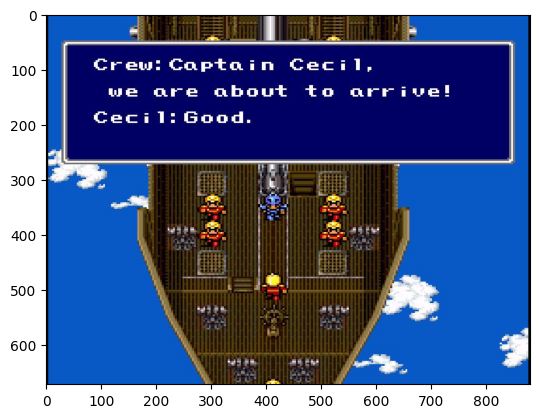

INFO:root:OCR found text: Crew: Coptoin Cecil, We ore about t0 arrivel Ceci :Good,
INFO:root:Time taken: 1.681290626525879 seconds


found text ocr----
Crew: Coptoin Cecil, We ore about t0 arrivel Ceci :Good,
----
Time taken: 1.681290626525879 seconds
{'id': 'chatcmpl-9TjKqC0Z5FQEY8UI8IbDTdPylrvc1', 'object': 'chat.completion', 'created': 1716872808, 'model': 'gpt-4o-2024-05-13', 'choices': [{'index': 0, 'message': {'role': 'assistant', 'content': 'Sure, here is the translated sentence in Japanese:\n\nクルー: セシル船長、到着間近です！\nセシル: よし。'}, 'logprobs': None, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 31, 'completion_tokens': 33, 'total_tokens': 64}, 'system_fingerprint': 'fp_43dfabdef1'}
{'id': 'chatcmpl-9TjKqC0Z5FQEY8UI8IbDTdPylrvc1', 'object': 'chat.completion', 'created': 1716872808, 'model': 'gpt-4o-2024-05-13', 'choices': [{'index': 0, 'message': {'role': 'assistant', 'content': 'Sure, here is the translated sentence in Japanese:\n\nクルー: セシル船長、到着間近です！\nセシル: よし。'}, 'logprobs': None, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 31, 'completion_tokens': 33, 'total_tokens': 64}, 'system_fingerprint': 'f

In [14]:
num = 1
img_path = img_fld.joinpath(f"{num}_window_capture.jpg")
print(img_path)
print(img_path.name)
image = Image.open(img_path)
plt.imshow(image)
plt.show()

# OCR
res, _, _, _ = fp.run_ocr(image)

for i in range(10):
    response = api.call_translation_api(res, 'japanese')
    
    print(response)
    # print(response['choices'][0]['message']['content'])
    # print(clean_vision_model_output(response))


# Error Analysis

Basically trying to see what is the difference between prompts.

In [17]:
def load_json(filename):
    '''return a dict {filename : ocr text}'''
    with open(filename, 'r') as f:
        data = json.load(f)
    
    data = {Path(k).name : v for k,v in data.items()}
    return data
        

## English

In [22]:
image_folder = Path("../data/data_en/")
gpt4o_new_json_file = Path("../data/translation_responses_en_gpt4o.json")
gpt4o_old_json_file = Path("../data/translation_responses_en_gpt4o_old_prompt.json")
dialogue_box_folder = Path("../data/dialogue_boxes_en_gpt4o")

In [23]:
data_new = load_json(gpt4o_new_json_file)
data_old   = load_json(gpt4o_old_json_file)

## compare text outputs only

In [31]:
count = 0
for img_path in list(image_folder.iterdir()):
    print('-'* 100)
    img = Image.open(img_path)
    print(img_path.name )
    if type(data_old[img_path.name]) is str:
        print(data_old[img_path.name])
    else:
        print('gpt4o old Prompt\t:',data_old[img_path.name]['choices'][0]['message']['content'])
        print('gpt4o new Prompt\t:',clean_vision_model_output(data_new[img_path.name]['choices'][0]['message']['content']))


----------------------------------------------------------------------------------------------------
0_window_capture.jpg
gpt4o old Prompt	: 乗組員: キャプテン・セシル、もうすぐ到着します！
セシル: よし。
gpt4o new Prompt	:  乗組員: セシル船長、もうすぐ到着です。 セシル: よかった。 
----------------------------------------------------------------------------------------------------
100_window_capture.jpg
gpt4o old Prompt	: 王様：「任務の成功を感謝します。さて、それはどこにありますか？」
gpt4o new Prompt	:   王様：彼は任務を成功させてくれたことを感謝している。さて、それはどこにあるのだ？  
----------------------------------------------------------------------------------------------------
101_window_capture.jpg
gpt4o old Prompt	: セシ：ここにおります。陛下。1 1
gpt4o new Prompt	: 「こちらです、我が君。」
----------------------------------------------------------------------------------------------------
102_window_capture.jpg
gpt4o old Prompt	: セシ: こちらです、陛下。1 1
gpt4o new Prompt	:  セシ：ここです、我が君。1 1 
----------------------------------------------------------------------------------------------------
103_window_capture.jpg
gpt4o old Prompt	